## read first!

This is all still work in progress. Please look at the to-do list below to see a list of features that don't exist now, but will soon. In addition to this demo and this wall of text, there are docstrings for all of the methods I expect to be useful: see https://qick-docs.readthedocs.io/en/latest/_autosummary/qick.asm_v2.html#qick.asm_v2.QickProgramV2

Please don't share this notebook or the firmware. (Yes, I realize they're publicly accessible, this is not top secret or anything but I don't want to be fielding questions at this point from people who don't have the right expectations.)

I expect that the text and examples here will all make their way into ReadTheDocs and qick_demos eventually.

If you're reading this, I am asking you to test the new tProc v2 software and help us get this into shape for public release. I am really asking you for a favor here. What I want from you is:
* What were you doing in tProc v1 that isn't shown in these examples? The firmware almost certainly supports it. Maybe the software does support it, but these examples and docs are inadequate. Maybe the software doesn't support it. Either way, I want to know.
* What do you want to do with tProc v2 that you couldn't do (or couldn't do easily) in tProc v1? Maybe the firmware supports it.
* What's in the to-do list that you want to use ASAP?
* What bugs or unexpected behaviors did you run into?

The peripherals (generators, readouts, buffers) are all unchanged. They work like before (same features, limitations, bugs), and are controlled like before. What has changed is how the tProc works at a firmware level, and how you write programs at a software level to tell it what to do.

### fundamental (enabled by firmware, taken advantage of in software) changes
There is a lot more stuff in the tProc v2 (new features and improvements) that I'm not listing here because the software doesn't yet give you an easy way to access it.

* It is much easier to switch between pulse definitions on a given generator channel because pulse information gets stored in a "waveform memory" instead of weird dedicated registers.
    * This is true on a Python level (you don't have to futz with regwi or run set_pulse_registers() before every pulse, you can just define multiple pulses in initialization and play them as needed) and on an ASM level (the tProc should be able to run your program faster because it's doing one waveform load instead of 5 regwi's)
* Instruction execution is pipelined, which should mean an increase in instructions executed per tProc clock cycle.
* v2 supports larger numbers of tProc outputs, and therefore more generators (without resorting to tProc multiplexing).
    * This could be leveraged to make the tProc-controlled readout the standard, allowing for readout frequency sweeps
* There are dedicated digital outputs, so instead of a single tProc output that drives all the triggers and PMOD pins you can have a mix of "digital ports" (multi-bit outputs) and "trigger ports" (single-bit outputs). This matters because output commands need to be dispatched in timeline order, so if pulse A is before pulse B in your program, pulse A must have an earlier time - you can't sweep the pulse times past each other even if they're on different pins. But now it's not a problem, as long as A and B are on different ports.
* All registers are on the same page (nice), but there are only 16 of them (not nice). Since you don't use registers for waveform operations and there are dedicated registers for various things, this is probably just fine. You will use registers for loop counters, swept times (pulse/trigger times, delays, waits), and math operations. If you run low on registers, you could use the data memory.
* This probably won't impact you, but the tProc now has two clocks: a "core" clock that controls execution, and a "timing" clock that controls the timed queues. The timing clock is almost always the one you care about: waits, delays, and pulse/trigger times are in units of timing ticks, and the tProc outputs are synchronized on the timing clock. The core clock (typically 200 MHz) just determines how fast your instructions execute. If I just say "tProc clock," it's the timing clock.

### new software features
* There's only one program wrapper and it is called AveragerProgramV2; it is inspired by Chao's NDAveragerProgram and works similarly. It's sufficiently simple and flexible that I don't think there's any reason to port over the old AveragerProgram and RAveragerProgram - you don't need to use sweeps or loops if you don't want to.
    * The only clear missing piece is that there isn't a way to write arbitrary code that gets executed after each loop (like `RAveragerProgram.update()`). This is not hard to add, and I'll get to it eventually, but I think sweeps remove most of the need for this sort of thing.
* Timeline management is smarter: you can sweep delays, you can sweep pulse times and lengths and have them be correctly accounted for by a `delay_auto`.
* Some little stuff for convenience
    * `run()` and `run_rounds()` methods for running a program when you haven't declared any readouts, or don't care about the acquired data
    * `get_time_axis()` method to get an array you can use as the X-axis when plotting decimated data
 
### discretionary software-level changes from v1
These changes are negotiable - I made them because we're starting from a clean slate and I think life is better with these changes. If you don't like anything in this list, we can switch it back to the v1 way (or a third way that you think is better).

Some jargon has gotten changed (either it was used inconsistently before, or the word was misleading):
* An "envelope" is an I/Q array (like a Gaussian) that you want to mix with a carrier. This was previously called a pulse.
* A "waveform" or "wave" is a single set of generator settings. There was no real word for this before.
    * Under the hood, this gets sent to the generator as a single instruction. In v1, a waveform was stored in a bunch of registers and dispatched with `set`. In v2, it gets stored as a single word in the waveform memory, which gets loaded to a dedicated waveform register and dispatched with `WPORT_WR`.
* A "pulse" is the thing you play with pulse(), and is made up of a list of waveforms. Const and arb pulses are single waveforms; flat-top pulses are composed of three waveforms.
* "Delay" is the new name for sync - I think it better expresses the effect and purpose, which are to increment the reference time and delay the timeline.
* Similarly, "wait_auto"/"sync_all" are now "wait_auto"/"delay_auto" since the distinction is that wait/delay just use the time value that you provide, while wait_auto/delay_auto automatically determine an appropriate time value.
* "Soft average" is the name for running a program repeatedly and averaging the results. This was called "rounds" in some contexts before; "rounds" is now only used for the case where you run a program repeatedly without saving the results at all.
* A "shot" means running the code in your innermost loop once, a "rep" means repeating your measurement (depending on your `reps_innermost` setting, this will happen by running through all of your sweeps N times or by taking N shots at each sweep step).

Some API conventions have changed:
* All parameters are in "natural" units.
    * Times in us, freqs in MHz, phase in degrees.
    * Gains are [-1,1] relative to the max amplitude possible for that pulse type - so +/- 1 in v2 is equivalent to +/- 32766 in v1, and it is still true that const pulses have double amplitude compared to arb or flat-top.
    * This means that your values (and step size, if sweeping) will get rounded. You can get the rounded values out of your program with `get_pulse_param()`.
    * There isn't proper bounds-checking for most parameters; out-of-bounds values just get wrapped. This is useful behavior for some parameters (freq, phase) but not for others (gain). This will get done eventually.
* The recommended end-of-shot boilerplate (do a wait_auto to complete your readout, then a delay_auto() to pad the timeline by relax_delay) is now done for you based on `final_wait` and `final_delay` parameters. Same for the end-of-initialization sync, which is now done based on `initial_delay`.
* The program config dictionary no longer has any "required" keys (like "reps" or "soft_avgs") for configuring the wrapper code. It's just to pass your custom parameters to your _initialize() and _body(); you don't even need to provide a config dictionary if your program doesn't use it. Instead there are method parameters:
    * The AveragerProgramV2 constructor wants `reps`, `final_delay`, `final_wait`, `initial_delay`.
    * acquire()/acquire_decimated() wants `soft_avgs`. This makes it easy to rerun the same program with different numbers of soft averages.
* The formatting of the acquired data has changed so the I/Q axis is innermost instead of outermost. This reflects the native data structure, and also makes it easy to convert to complex with `.dot([1,1j])`.
* Loops are ordered as "first declared is outermost", in contrast to NDAveragerProgram which orders loops as "first declared is innermost." I just think this makes more sense?
    * The "reps" loop defaults to the outermost loop, in contrast to RAverager and similar to NDAverager - this reduces sensitivity to slow drifts. You can change this by setting `reps_innermost=True`.
* There's no `adc_trig_offset` parameter, you just specify the trigger time as `t`. Those two parameters just got summed anyway, it wasn't like the default value of `adc_trig_offset` would work for everyone, and the name `adc_trig_offset` made this parameter sound like it was doing something special.
* `body()` and `initialize()` are now `_body()` and `_initialize()`, to (hopefully) communicate that these are called by the boilerplate code in `AveragerProgramV2.make_program()`, and should not be called by user code.
* Gaussian envelopes suffered from an ancient bug, where their sigma was actually sigma/sqrt(2). This is fixed.

### to-do list for Sho (not in order)
needed before general release:
* QickConfig printout showing v2-specific info
* make print(prog) less hideous and more useful
* probably a lot of error checking
* replacements for everything in qick_demos
* clean up readthedocs
* decide on configuration of new standard firmwares
* get rid of v2 assembler's assembler.log file
* test reset_gens

nice to have:
* correctly account for which gens a pulse can be played on (right now nothing stops you from defining a pulse on one gen and playing it on another, but it won't always work)
* print useful stuff like tmux groups and tport/dport info in soccfg
* bounds-checking, e.g. raising an error on out-of-range gains
* t0 offset handling
* PRNG
* multi-board stuff
* make the assembler use logging instead of the assembler.log file
* there might be new things in the instruction set which I'm not taking advantage of
* wait for input data using s_status
* a way to toggle PMOD pins, not just pulse them
* convenience methods for phase reset
* store standard envelope shapes in parametrized form instead of numpy arrays
* external start

## setup

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

In [3]:
# use pyro's traceback code instead of ipython's (optional)
# adapted from https://pyro4.readthedocs.io/en/stable/errors.html and https://stackoverflow.com/a/70433500
import IPython
import Pyro4.util
import sys

from IPython import get_ipython
ip = get_ipython()

def exception_handler(self, etype, evalue, tb, tb_offset=None):
    sys.stderr.write("".join(Pyro4.util.getPyroTraceback()))
    # self.showtraceback((etype, evalue, tb), tb_offset=tb_offset)  # standard IPython's printout

ip.set_custom_exc((Exception,), exception_handler)  # register your handler

### firmware
This demo is using the firmware in https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2024-05-29_111_tprocv2r20_rfbv2/.
This is a ZCU111 firmware, compatible with the RF board v2, though for these tests I'm just using the balun board and QickSoc.
If you're using an RF board you would use RFQickSocV2, same as before.
The firmware project is https://github.com/awsch/qick-spin/blob/main/firmware/proj_111_rfbv2.tcl (and uses the IP versions in that repo, specifically core revision 20 of the tProc v2).

The demo also works with the firmware in https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2024-08-07_216_tprocv2r20_q3diamond/, which is built using the project files found there.

There are some other 4x2 and 216 firmwares with tProc v2 - some for testing and some for specific applications. These firmwares are all pretty different from the "standard" firmwares and the firmwares being used for superconducting qubits, also the version of the tProc v2 core is not consistent. So if you want a firmware for your board, ask whoever made your current firmware to make you a new v2 firmware. The firmware config printout shows the revision of your tProc v2.


In [4]:
# # soc = QickSoc('../../qick_lib/qick/qick_4x2.bit')
# soc = QickSoc('../../firmware/pynq_files/qick_4x2_jac.bit')
# # soc = QickSoc('../../qick_lib/qick/qick_4x2.bit',force_init_clks=True)

# print(soc)
# print(soc.tproc)

In [5]:
from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host="pynq4x2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# soc, soccfg = make_proxy(ns_host="pynq216.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
soc, soccfg = make_proxy(ns_host="pynq111-2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_abca72d6608a45268ba0768340b9a8d1@131.225.86.201:41891
QICK running on ZCU111, software version 0.2.280

Firmware configuration (built Wed May 29 20:43:01 2024):

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is DAC228_T0_CH1 or RF board output 1
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is DAC228_T0_CH2 or RF board output 2
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=38

In [6]:
# ZCU111
GEN_CH = 7
RO_CH = 0
TRIG_TIME = 0.30
FREQ = 500

# # ZCU216, full-speed gen
# GEN_CH = 0
# RO_CH = 6
# TRIG_TIME = 0.40
# FREQ = 500

# # ZCU216, int4 gen (you'll need to set mixer_freq in declare_gen)
# GEN_CH = 2
# RO_CH = 6
# TRIG_TIME = 0.40
# FREQ = 500

# 4x2
# GEN_CH = 0
# RO_CH = 0
# TRIG_TIME = 0.30
# FREQ = 500

## basic multi-pulse program
Just a "reps" loop, no sweeping - like v1 AveragerProgram.

In v2, you define all of your pulses, and then you can play them as needed. Contrast to v1, where only one pulse could be defined on a generator at a time.

  0%|          | 0/10 [00:00<?, ?it/s]

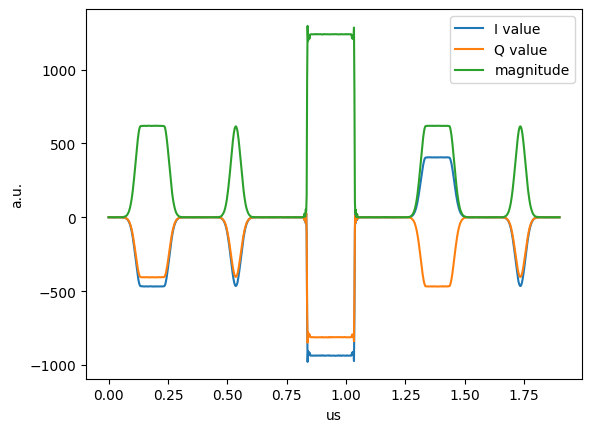

In [7]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [8]:
# print the program - ugly!
print(prog)

macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f58283ba790>}, t_regs={'t': 384})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.3, width=0.026041666666666668, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f58285019d0>, 'width': <qick.asm_v2.QickParam object at 0x7f58283baa90>}, t_regs={'t': 115, 'width': 10}, outdict=defaultdict(<class 'int'>, {1: 5, 0: 1}), trigset=set())
	Pulse(ch=7, name='myflattop', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f58283bac50>}, t_regs={'t': 0})
	Pulse(ch=7, name='mygaus', t=0.4, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f58283bab90>}, t_regs={'t': 154})
	Pulse(ch=7, name='myconst', t=0.8, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f58283babd0>}, t_regs={'t': 307})
	Pulse(ch=7, name='myflattop2', t=1.2, tag=None, t_params={'t': <qick.asm_v2.QickPa

## basic sweep program
Let's play a pulse - we'll just use flat-top because it's the most complicated.

In [9]:
class SimpleSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("myloop", self.cfg["steps"])

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/10 [00:00<?, ?it/s]

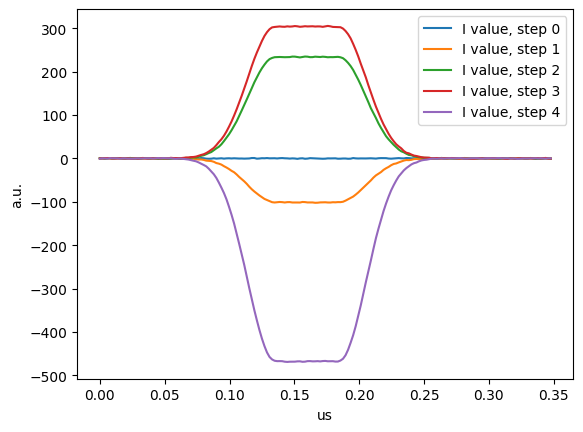

In [10]:
# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("myloop", -360, 720),
          'gain': QickSweep1D("myloop", 0.0, 1.0)
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [11]:
print(prog)

macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5825793610>}, t_regs={'t': 384})
	OpenLoop(n=1, name='reps')
	OpenLoop(n=5, name='myloop')
	Pulse(ch=7, name='mypulse', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f582844d890>}, t_regs={'t': 0})
	Trigger(ros=[0], pins=[0], t=0.3, width=0.026041666666666668, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f582843a910>, 'width': <qick.asm_v2.QickParam object at 0x7f5825793990>}, t_regs={'t': 115, 'width': 10}, outdict=defaultdict(<class 'int'>, {1: 1, 0: 1}), trigset=set())
	Wait(t=0, auto=True, gens=False, ros=True, tag=None, no_warn=True, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5825793ad0>}, t_regs={'t': 249})
	Delay(t=0.5, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5828481690>}, t_regs={'t': 441})
	IncReg(dst='s_core_w

  0%|          | 0/20100 [00:00<?, ?it/s]

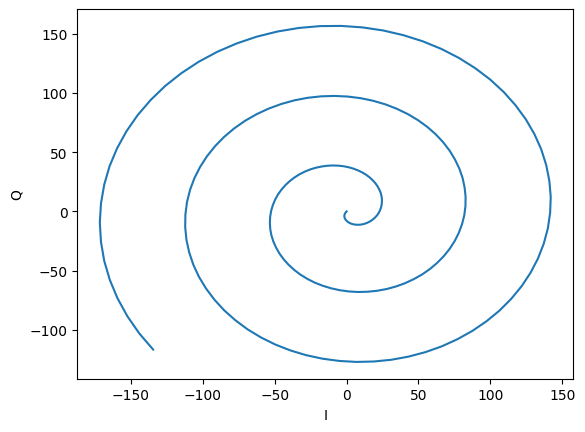

In [12]:
# do a higher-res sweep with acquire()
config['steps']=201
prog = SimpleSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("Q")
plt.xlabel("I");

  0%|          | 0/20100 [00:00<?, ?it/s]

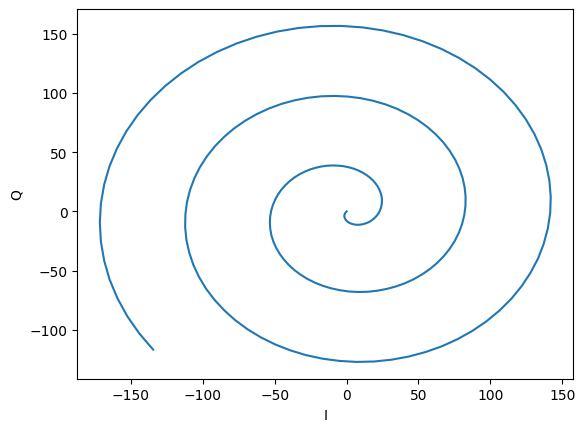

In [13]:
# test that we can dump to a JSON string and restore (for tech support, or AWS sideQICK)
from qick.asm_v2 import AcquireProgramV2
from qick.helpers import progs2json,json2progs
s = progs2json([prog.dump_prog()])

d = json2progs(s)
newprog = AcquireProgramV2(soccfg)
newprog.load_prog(json2progs(s)[0])
iq_list = newprog.acquire(soc, soft_avgs=1)
plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("Q")
plt.xlabel("I");

  0%|          | 0/10 [00:00<?, ?it/s]

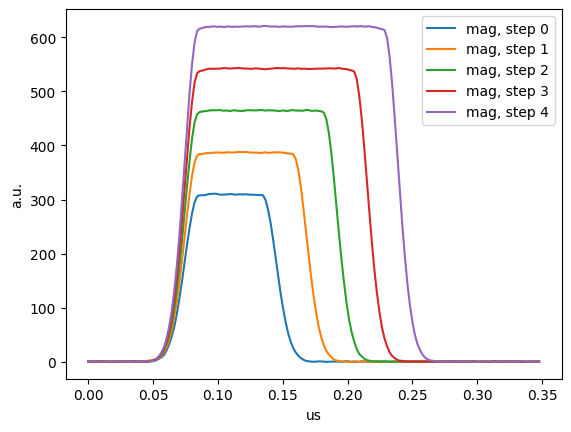

In [14]:
# we can sweep lengths too
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': QickSweep1D("myloop", 0.05, 0.15),
          'ramp_len': 0.1,
          'phase': 0,
          'gain': QickSweep1D("myloop", 0.5, 1.0)
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.figure(1)
for ii, iq in enumerate(iq_list[0]):
    # plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

## multi-dimensional loops and sweeps
If you want an N-dimensional looping program, you just need to call add_loop() multiple times. Each swept value should reference the name of the loop you want the sweep to happen in. (You can sweep over the "reps" loop if you want, but then your averaging will not make sense.)

If you want a value that gets swept in more than one loop level, you need to build a sweep object by summing the initial value with some "spans," where each span is the range that you sweep over in a given loop.
QickSweep1D is actually just a convenience function that builds a 1-D sweep using this machinery.

Just for fun, we'll also trigger the DDR4 and MR buffers in this program.

In [15]:
# one flat-top pulse, two user-defined loop levels
class Sweep2DProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("loop1", self.cfg["steps1"]) # this will be the outer loop
        self.add_loop("loop2", self.cfg["steps2"]) # this will be the inner loop
        # the reps loop is always outermost, so the order and the shape of the raw data will be (reps, loop1, loop2)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.delay(0.5) # give the tProc some time for initial setup
        self.trigger(ddr4=True, mr=True, t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
     

  0%|          | 0/500000 [00:00<?, ?it/s]

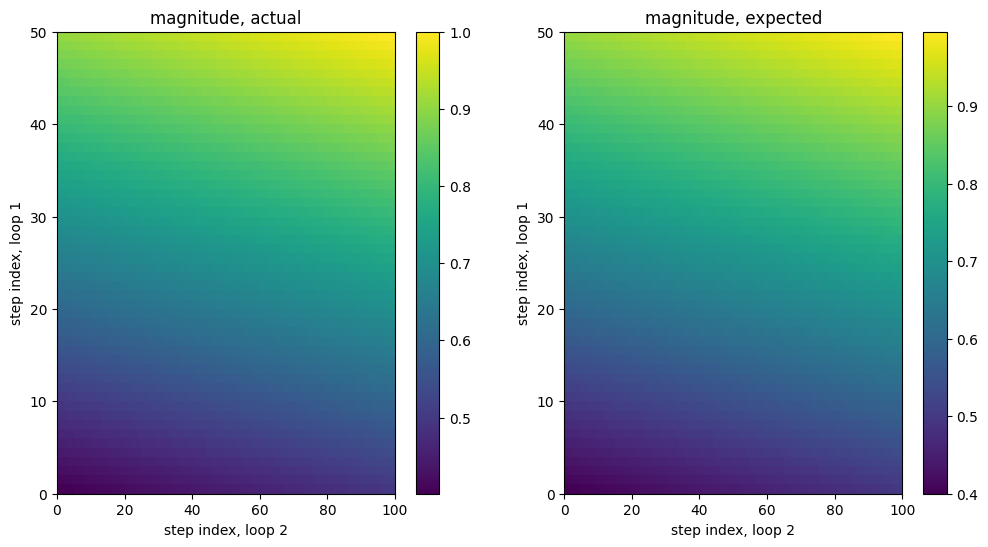

In [16]:
# sweep the gain over both loop levels
# I don't think you would ever want this, exactly, but:
# if you have a multi-D scan where you sweep two durations you may end up with an auto-swept delay that sweeps on both axes
# so it's good to understand that this machinery exists, and works correctly

# see how you can get the grid of sweep values out of the program

config = {'steps1': 50,
          'steps2': 100,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': 0,
          # initial value 0.4, sweep by 0.5 in loop1 and by 0.1 in loop2, in other words:
          # the very first shot is 0.4
          # the first loop2 sweep runs from 0.4 to 0.5
          # the last loop2 sweep runs from 0.9 to 1.0
          'gain': 0.4 + QickSpan("loop1", 0.5) + QickSpan("loop2", 0.1)
         }

prog = Sweep2DProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
# plt.plot(iq_list[0][0,0,:,0], iq_list[0][0,0,:,1])
mag = np.abs(iq_list[0][0].dot([1,1j]))

fig, axes = plt.subplots(1,2, figsize=(12,6))
plot = axes[0]
plt.colorbar(plot.pcolormesh(mag/mag.max()))
plot.set_title("magnitude, actual")
plot.set_ylabel("step index, loop 1")
plot.set_xlabel("step index, loop 2");

plot = axes[1]
plt.colorbar(plot.pcolormesh(prog.get_pulse_param('mypulse', 'gain', as_array=True)))
plot.set_title("magnitude, expected")
plot.set_ylabel("step index, loop 1")
plot.set_xlabel("step index, loop 2");

In [17]:
# usually you will use get_pulse_param to query the program for your sweep points
# but get_actual_values() also works (this exists mostly for QICK wrappers like the qcodes driver)
print(prog.get_pulse_param('mypulse', 'gain', as_array=True))
print(config['gain'].get_actual_values(prog.loop_dict))

[[0.39998779 0.40096441 0.40194104 ... 0.49472014 0.49569676 0.49667338]
 [0.41018129 0.41115791 0.41213453 ... 0.50491363 0.50589025 0.50686687]
 [0.42037478 0.4213514  0.42232802 ... 0.51510712 0.51608375 0.51706037]
 ...
 [0.87908198 0.8800586  0.88103522 ... 0.97381432 0.97479094 0.97576756]
 [0.88927547 0.89025209 0.89122871 ... 0.98400781 0.98498444 0.98596106]
 [0.89946896 0.90044558 0.90142221 ... 0.99420131 0.99517793 0.99615455]]
[[[0.39998779 0.40096441 0.40194104 ... 0.49472014 0.49569676 0.49667338]
  [0.41018129 0.41115791 0.41213453 ... 0.50491363 0.50589025 0.50686687]
  [0.42037478 0.4213514  0.42232802 ... 0.51510712 0.51608375 0.51706037]
  ...
  [0.87908198 0.8800586  0.88103522 ... 0.97381432 0.97479094 0.97576756]
  [0.88927547 0.89025209 0.89122871 ... 0.98400781 0.98498444 0.98596106]
  [0.89946896 0.90044558 0.90142221 ... 0.99420131 0.99517793 0.99615455]]]


  0%|          | 0/500000 [00:00<?, ?it/s]

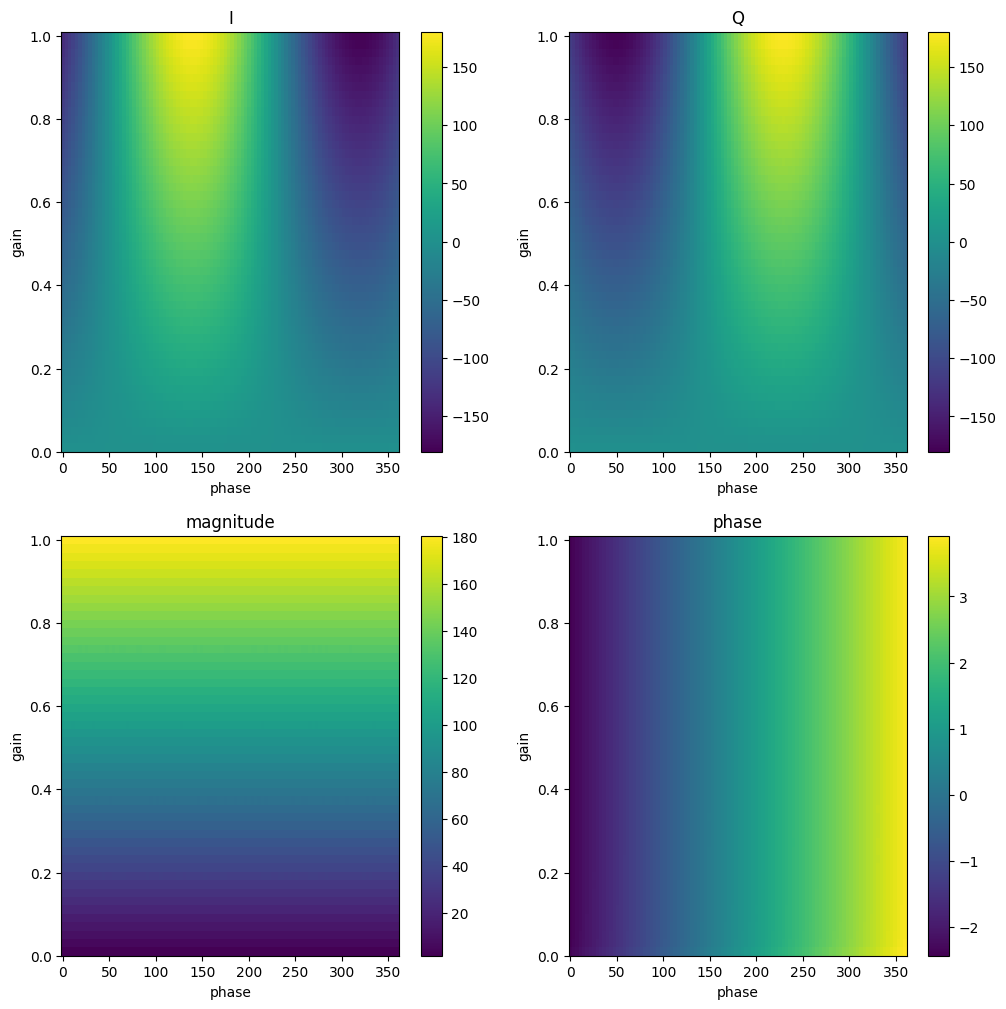

In [18]:
# now do a gain+phase sweep similar to Chao's 07_Sweep_ND demo
config = {'steps1': 50,
          'steps2': 100,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("loop2", 0, 360),
          'gain': QickSweep1D("loop1", 0.01, 1.0)
         }

prog = Sweep2DProgram(soccfg, reps=100, final_delay=1.0, cfg=config)

iq_list = prog.acquire(soc, soft_avgs=1, progress=True)

fig, axes = plt.subplots(2, 2, figsize=(12,12))

# get the exact values of the parameters, after rounding - this also works for scalars (without as_array), you will just get a float
phases = prog.get_pulse_param("mypulse", "phase", as_array=True)
gains = prog.get_pulse_param("mypulse", "gain", as_array=True)

plot = axes[0,0]
plt.colorbar(plot.pcolormesh(phases, gains, iq_list[0][0,:,:,0]), ax=plot)
plot.set_title("I")
plot.set_ylabel("gain")
plot.set_xlabel("phase")
plot = axes[0,1]
plt.colorbar(plot.pcolormesh(phases, gains, iq_list[0][0,:,:,1]), ax=plot)
plot.set_title("Q")
plot.set_ylabel("gain")
plot.set_xlabel("phase")

plot = axes[1,0]
plt.colorbar(plot.pcolormesh(phases, gains, np.abs(iq_list[0][0].dot([1,1j]))), ax=plot)
plot.set_title("magnitude")
plot.set_ylabel("gain")
plot.set_xlabel("phase")

plot = axes[1,1]
plt.colorbar(plot.pcolormesh(phases, gains, np.unwrap(np.angle(iq_list[0][0].dot([1,1j])), axis=1)), ax=plot)
plot.set_title("phase")
plot.set_ylabel("gain")
plot.set_xlabel("phase");

In [19]:
# similar sweep, but use the DDR4 buffer to see the loop order
config = {'steps1': 4,
          'steps2': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("loop2", 0, 180),
          'gain': QickSweep1D("loop1", 0.5, 1.0)
         }

prog = Sweep2DProgram(soccfg, reps=3, final_delay=1.0, cfg=config)

n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
# Arm the buffers
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)
soc.arm_mr(ch=RO_CH)

iq_list = prog.acquire(soc, soft_avgs=1, progress=True)

  0%|          | 0/60 [00:00<?, ?it/s]

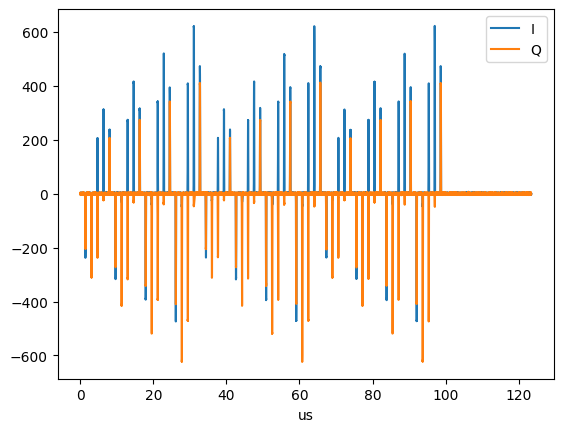

In [20]:
# now you see the loop order: innermost loop of 5 phase steps, mid loop of 4 gain steps, outer loop of 3 identical reps
iq_ddr4 = soc.get_ddr4(250)
t = prog.get_time_axis_ddr4(RO_CH, iq_ddr4)

plt.plot(t, iq_ddr4[:,0],label="I")
plt.plot(t, iq_ddr4[:,1],label="Q")
# plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
plt.xlabel("us")
plt.legend();

  0%|          | 0/60 [00:00<?, ?it/s]

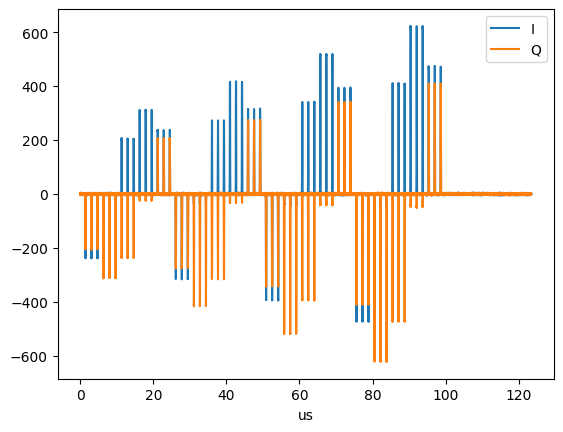

In [21]:
# look at the different loop ordering with reps_innermost
# innermost loop of 3 identical reps, mid loop of 5 phase steps, outermost loop of 4 gain steps

prog = Sweep2DProgram(soccfg, reps=3, final_delay=1.0, cfg=config, reps_innermost=True)

n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
# Arm the buffers
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

iq_list = prog.acquire(soc, soft_avgs=1, progress=True)

iq_ddr4 = soc.get_ddr4(250)
t = prog.get_time_axis_ddr4(RO_CH, iq_ddr4)

plt.plot(t, iq_ddr4[:,0],label="I")
plt.plot(t, iq_ddr4[:,1],label="Q")
# plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
plt.xlabel("us")
plt.legend();

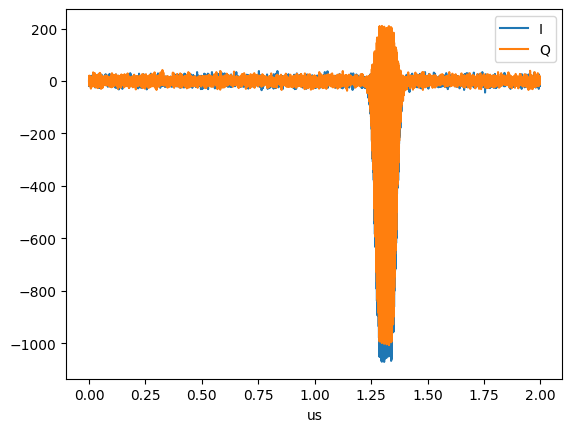

In [22]:
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()
t = prog.get_time_axis_mr(RO_CH, iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

Text(0.5, 0, 'MHz')

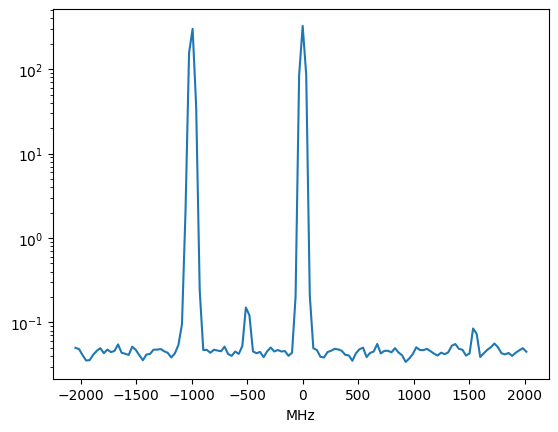

In [23]:
# plot the FFT - note that because we subtract the downconversion frequency, the image tone shows up at -2f
from scipy.signal import welch
from numpy.fft import fftshift
fs_mr = soccfg['readouts'][RO_CH]['fs']
fft_freqs, psd = fftshift(welch(iq_mr.dot([1,1j]), fs_mr, return_onesided=False, nperseg=128, detrend=False), axes=1)
plt.semilogy(fft_freqs, psd)
plt.xlabel("MHz")

## timeline management
* you can sweep almost any time/duration parameter:
    * time parameter for pulse/trigger
    * time parameter for delay
    * length of a const pulse or the flat segment of a flat-top pulse
* "auto" (for pulse times and delay/wait) is smarter now
    * if your sweeps result in the end of the last pulse/readout getting swept relative to the reference time, "auto" should correctly account for this
    * if you use a delay that doesn't push the reference time past the end-of-pulse, the end-of-pulse will be decremented by the delay (in v1 this was all-or-nothing, sync_all would zero all end-of-pulse timestamps but synci would do nothing)
    * you can tell wait_auto/delay_auto to ignore generator times or readout times - the default (same as v1) is that wait_auto pays attention to readouts only, while delay_auto pays attention to both gens and ROs
* while "auto" is smarter now, I still want to encourage using explicit times when possible
    * this is easier now that all times and durations are in the same units, right?
    * my instinct is that it's safer if people "keep their hands on the wheel" - make them think about what they are doing, vs. letting them rely on safe-ish defaults
    * "auto" is still somewhat fragile - it doesn't know about jumps, there are probably some edge cases (multiple channels with swept times?) where the math doesn't work out
    * again, "auto" doesn't know about jumps! in general the software does not understand the structure of your program, and specifically the timeline management code assumes that your instructions are just executed in the order that they appear in the program. since "auto" is evaluated in software and not in the tProc, it is fundamental that it can only convert to one (possibly swept) value, even if the auto-timed instruction can be reached in more than one way. so:
        * if you skip some instructions with a jump (conditional or not), an "auto" after the skipped instructions will behave as though nothing was skipped
        * if you jump backwards (e.g. a loop inside your body), an "auto" inside the repeated section will have the correct duration for the first pass through the section, but on later passes that value may not be what you wanted
        * if you use a subroutine, an "auto" inside the subroutine will not know the state of the timeline from before the subroutine was called; an "auto" after the call-and-return will not account for any timed instructions that happened inside the subroutine
    * swept times consume registers, which are somewhat precious (print(prog) will list all the allocated registers)
    * for these reasons, the default t in `pulse()` is now 0, not auto (as it was in v1)

  0%|          | 0/10 [00:00<?, ?it/s]

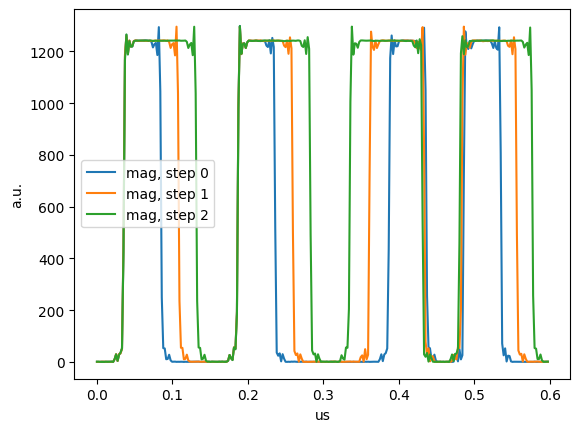

In [24]:
# goofing around with timeline management
# I don't imagine you would ever do this, this is just to show you how things work
class DelayProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("myloop", self.cfg["steps"])

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const",
                       freq=cfg['freq'], 
                       length=QickSweep1D("myloop", 0.05, 0.1),
                       phase=cfg['phase'],
                       gain=cfg['gain'],
              )
        
    def _body(self, cfg):
        # let's keep track of things in absolute time, with start-of-shot = 0
        
        # schedule the readout trigger
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], tag='trig')
        # the 1st pulse will start at absolute time 0
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        # now we increment the reference time by 0.15, which takes us to after the end of the 1st pulse
        # by the way - if you shrink this to 0.05 or something, you will get a warning that your pulses are colliding
        # please don't rely too much on this safety check . . .
        self.delay(0.15, tag='delay1')
        # the 2nd pulse will start at absolute time 0.15
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        # ros=False tells "auto" to ignore the readouts - only pay attention to when the pulses end
        # we then add another sweep on that: "push the reference time to 0.15 to 0.05 us after the end of the last pulse"
        # that end time sweeps from 0.2 to 0.25, so the new reference time is 0.35 to 0.3
        self.delay_auto(QickSweep1D("myloop", 0.15, 0.05), ros=False, tag='delay2')
        # the 3rd pulse will start at 0.35 to 0.3, and always end at 0.4 (modulo rounding)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        # the 4th pulse will start at 0.1 to 0.15 after the reference, so always 0.45 (modulo rounding)
        # it'll end at 0.5 to 0.55
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=QickSweep1D("myloop", 0.1, 0.15), tag='pulse4')

        
config = {'steps': 3,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.6,
          'phase': 0,
          'gain': 1.0
         }

prog = DelayProgram(soccfg, reps=1, final_delay=1.0, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    # plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

Similar to `get_pulse_params()` for getting rounded values for a pulse parameter, you can use `get_time_param()` for getting rounded times+durations for a timed instruction. In order to use this, you need to add a "tag" to the specific timed instrucitons you want to query.

In [25]:
prog.get_time_param('delay1', 't')

0.15104166666666666

In [26]:
# swept parameters are returned as QickParam objects
# if you want an array, you need to use as_array or to_array()
# to_array() is useful because you can add a bunch of swept parameters and then convert with to_array()
print(prog.get_time_param('delay2', 't', as_array=True))
print(prog.get_time_param('delay2', 't').to_array(prog.loop_dict))

[0.20052083 0.17447917 0.1484375 ]
[0.20052083 0.17447917 0.1484375 ]


In [27]:
# so let's calculate the end time of the third pulse: it's not exactly 0.4 us
(prog.get_time_param('delay1', 't') + prog.get_time_param('delay2', 't') + prog.get_pulse_param('mypulse','total_length')).to_array(prog.loop_dict)

array([0.40104167, 0.3984375 , 0.39583333])

In [28]:
# if you need to check what parameters you can query, this is convenient
prog.list_pulse_params('mypulse')

['phase', 'gain', 'freq', 'length', 'total_length']

If you didn't want the phase rotation to persist, you'd want to reset the parameters at the end of your body:

## feedback
Feedback is basically the same as it was in tProc v1.

There is an instruction that reads an accumulated IQ value from a tProc input. You can write that value to data memory (to read it out for debugging), and you can do a conditional jump based on the value. Separately but relatedly, you can apply a software threshold to acquired data.

Similar to how we need to wait at the end of a shot so acquire() doesn't read the accumulated buffer before the data gets written there, we need to wait after a readout so the port read doesn't give us a stale value from the previous trigger.

Also keep in mind that the values returned by acquire() are length-normalized: they're equivalent to taking the average of the decimated samples. The raw IQ values (returned by get_raw() or seen at the tProc input) are not normalized, they're just the sum of the decimated values.

### tuning the readout latency
This procedure is similar to what you would have done in tProc v1 - read the same IQ value through the buffer and the tProc input, you want to make `read_wait` big enough that the two paths always give the same value.
The specific value will depend on your firmware but should be quite stable.

The tProc can also wait for new data on its input, which is smarter than waiting for a fixed delay that you need to tune, but this is not yet supported in software.

  0%|          | 0/1 [00:00<?, ?it/s]

buffered readout: [-12539. -10810.]
feedback readout: [-12539 -10810]


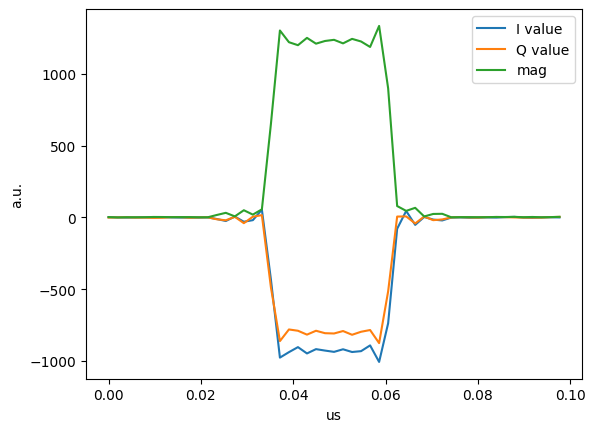

In [29]:
class ReadProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.wait_auto(cfg['read_wait'])
        self.read_input(ro_ch=cfg['ro_ch'])
        self.write_dmem(addr=0, src='s_port_l')
        self.write_dmem(addr=1, src='s_port_h')

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'read_wait': 0.1,
          'ro_len': 0.1,
          'flat_len': 0.025,
          'phase': 0,
          'gain': 1.0
         }

prog = ReadProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="mag")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

print("buffered readout:", iq_list[0].sum(axis=0))
print("feedback readout:", soc.read_mem(2,'dmem'))

### using feedback
Let's play a swept pulse, read it, and apply a threshold on the I value to decide whether to play a second pulse.
We should see that the second pulse is played if and only if we hit the threshold.

  0%|          | 0/10 [00:00<?, ?it/s]

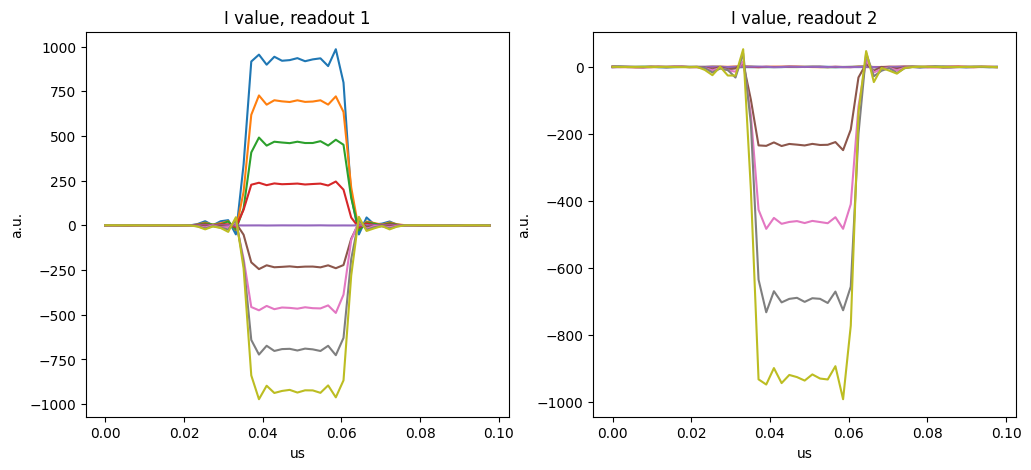

In [30]:
class FeedbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_loop("myloop", self.cfg["steps"])

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

    def _body(self, cfg):
        # pulse, and do a first readout
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        # we need to wait before executing the read
        # we also need to push the reference time past the wait
        # (whenever you wait, you need to ensure the reference time stays in the future)
        # the amount of extra delay needed will depend on how much code the tProc needs to execute between the wait and the next timed instruction
        # you can try shrinking the extra delay, at some point the second pulse will shift relative to the trigger
        # here are two equivalent ways to apply the needed wait and delay:

        # wait, then delay a bit extra
        self.wait_auto(cfg['read_wait'])
        self.delay_auto(cfg['read_wait'] + cfg['extra_delay'])
        
        # delay, wait until we reach the reference time, then delay a bit
        # self.delay_auto(cfg['read_wait'])
        # self.wait(0)
        # self.delay(cfg['extra_delay'])

        # trigger a second readout
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        # read the input, test a threshold, and jump
        self.read_and_jump(ro_ch=cfg['ro_ch'], component='I', threshold=cfg['threshold'], test='>=', label='NOPULSE')
        # this is a convenience method, and is equivalent to:
        # self.read_input(ro_ch=cfg['ro_ch'])
        # self.cond_jump(label='NOPULSE', arg1='s8', test='NS', op='-', arg2=cfg['threshold'])
        
        # code between the jump and the label will get skipped
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        # the label will be attached to the next instruction, which is going to be the end-of-shot code in make_program()
        self.label("NOPULSE")
        # if you feel more comfortable seeing the code you're labeling, you could insert a NOP here?
        # self.nop()


config = {'steps': 9,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'read_wait': 0.1,
          'extra_delay': 0.2,
          'threshold': 0,
          'ro_len': 0.1,
          'flat_len': 0.025,
          'phase': 0,
          'gain': QickSweep1D("myloop", -1.0, 1.0)
         }

prog = FeedbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)

t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
for iRead in range(2):
    plot = axes[iRead]
    for ii, iq in enumerate(iq_list[0]):
        plot.plot(t, iq[iRead,:,0], label="I value, step %d"%(ii))
        # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
        # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
    
    plot.set_title("I value, readout %d"%(iRead+1))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us")

  0%|          | 0/200 [00:00<?, ?it/s]

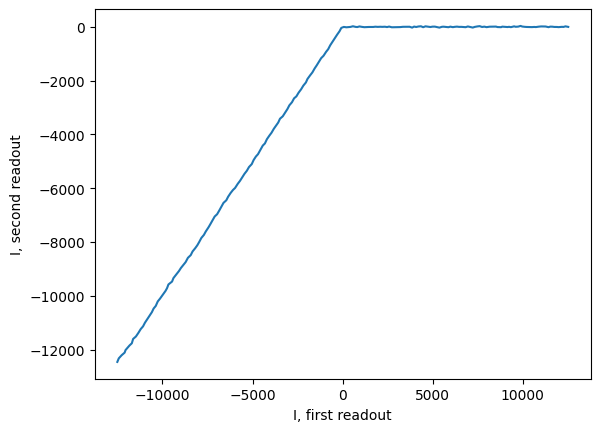

In [31]:
config['steps'] = 200

prog = FeedbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
gains = prog.get_pulse_param("mypulse", "gain", as_array=True)

iq_list = prog.acquire(soc, soft_avgs=1)

ro_len = len(prog.get_time_axis(ro_index=0))

# multiply the acquired I values by the length of the readout window, to undo length-normalization and get the raw units used for feedback
i_vals = iq_list[0][:,:,0]*ro_len
plt.plot(i_vals[0],i_vals[1])

plt.ylabel("I, second readout")
plt.xlabel("I, first readout");


  0%|          | 0/20000 [00:00<?, ?it/s]

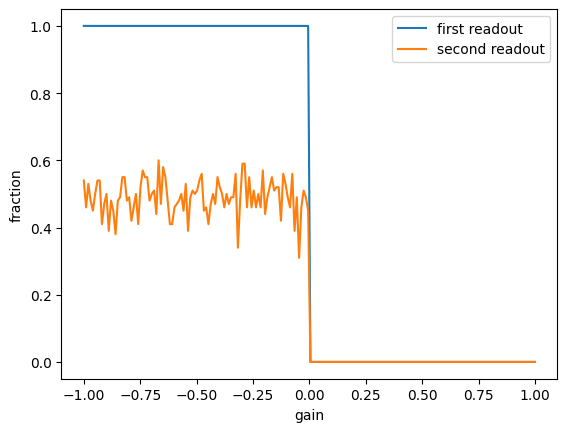

In [32]:
# let's test thresholded readout here, though it's not directly related to feedback
# this threshold is in length-normalized units
# the rotation angle is optional and in units of radians (seems odd but it has always been this way)
prog = FeedbackProgram(soccfg, reps=100, final_delay=0.5, cfg=config)
iq_list = prog.acquire(soc, soft_avgs=1, threshold=0, angle=0)
plt.plot(gains, iq_list[0][0,:,0], label="first readout")
plt.plot(gains, iq_list[0][1,:,0], label="second readout")
plt.legend()
plt.ylabel("fraction")
plt.xlabel("gain");

## register operations
There are three types of registers:
* Data registers have no defined purpose - they are for your program's use.
* Special registers each have some specific purpose.
* Waveform registers are used for manipulating waveforms. You can't modify values in the waveform memory directly; you need to read a waveform into the waveform registers, make changes in the waveform registers, and write back into the waveform memory. Each waveform parameter (freq, phase, env, gain, length, conf) gets its own register, but there's only one set of waveform registers (one waveform).

You can refer to registers in a few ways:
* The ASM code uses addresses of the form "r2" - one letter for the register type, then a number for the address. These are usually called "ASM addresses" or "full addresses."
* The special and waveform registers have "aliases" that describe their function, e.g. "s11" has the alias "s_usr_time".
* When you allocate a data register, you get to specify an arbitrary name.

Any of these forms is valid as a macro argument.

Here's a useless example program that moves some values around.

In [33]:
from qick.asm_v2 import QickProgramV2
# use QickProgramV2 to write the same program using asm_inst
prog = QickProgramV2(soccfg)
prog.add_reg(name='myaddr')

prog.set_ext_counter(addr=1, val=1000)
prog.set_ext_counter(addr=2, val=1000)
prog.write_reg(dst='myaddr', src=2)

prog.write_dmem(addr=3, src=10)
prog.read_dmem(dst='s_core_w1', addr=3)

prog.write_dmem(addr='myaddr', src=17)
prog.read_dmem(dst='s_core_w2', addr='myaddr')

prog.inc_reg(dst='myaddr', src=-1)
prog.write_dmem(addr='myaddr', src=19)
prog.end()

print("text ASM:")
print(prog.asm())

# print("machine code:")
# prog.compile()
# for a in prog.binprog['pmem']:
#     print([hex(b) for b in a])

soc.load_mem([1,2,3,4,5], 'dmem')

prog.run(soc)

print(soc.read_mem(5, 'dmem'))

print(soc.get_tproc_counter(1))
print(soc.get_tproc_counter(2))

text ASM:
     NOP 
     REG_WR s12 imm ##1000 
     REG_WR s13 imm ##1000 
     REG_WR r0 imm ##2 
     DMEM_WR [&3] imm ##10 
     REG_WR s12 dmem [&3] 
     DMEM_WR [&r0] imm ##17 
     REG_WR s13 dmem [&r0] 
     REG_WR r0 op -op(r0 + #-1) 
     DMEM_WR [&r0] imm ##19 
     JUMP HERE 

[ 1 19 17 10  5]
10
17


## pulse updates, subroutines
You might need to update pulse parameters dynamically in a way that's not covered by sweeps. Here we demonstrate this using a virtual-Z gate - we play the same gate four times, but do two pi/2 virtual-Z rotations. Note:
* The read+increment+write idiom here is the same way your sweeps are applied - if you define a swept pulse parameter, the waveforms are getting updated in this way at the end of each loop iteration.
* We need to loop over the waveforms in the pulse. (If you're worried about execution time - flat-top is the only pulse type that has multiple waveforms, and you probably wouldn't be using flat-top with virtual-Z.)
* Using a subroutine is totally optional (you could just paste the code into your body twice), but it does simplify the code; for long repetitive programs this could keep your program small.
* As mentioned above - the timeline management code in the software doesn't understand jumps. This subroutine neither affects nor cares about the timeline, so it's fine. If you put pulses inside a subroutine, you need to think about how they will fit with the rest of your timeline.
* This isn't the only way you could define a virtual-Z - you could define 4 sets of pulses, and switch which one you play, or you could keep track of the phase in a user register and apply it to your pulses when you play them - but those are less straightforward with the existing ASM macros.
* The update persists between shots, since you're modifying the waveform definition.

  0%|          | 0/10 [00:00<?, ?it/s]

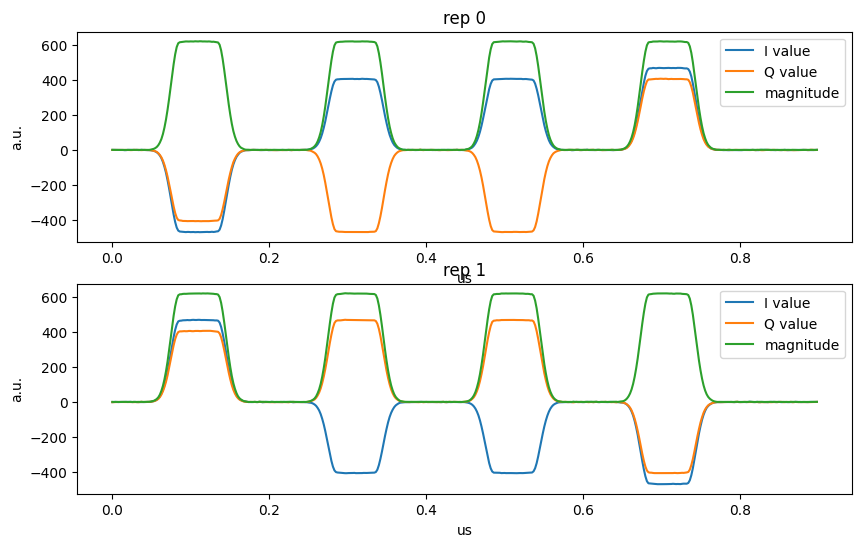

In [34]:
from qick.asm_v2 import AsmV2
class PulseUpdateProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.1
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.05,
                       phase=0,
                       gain=1.0, 
                      )

        sub = AsmV2()
        for wname in self.list_pulse_waveforms("myflattop"):
            sub.read_wmem(name=wname)
            sub.inc_reg(dst='w_phase', src=self.deg2reg(90, gen_ch=cfg['gen_ch']))
            sub.write_wmem(name=wname)
        self.add_subroutine("virt_z", sub)

    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.call("virt_z")
        # equivalent to:
        # for wname in self.list_pulse_waveforms("myflattop"):
        #     self.read_wmem(name=wname)
        #     self.inc_reg(dst='w_phase', src=self.deg2reg(90, gen_ch=cfg['gen_ch']))
        #     self.write_wmem(name=wname)
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0.2)
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0.4)
        self.call("virt_z")
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.9,
         }

prog = PulseUpdateProgram(soccfg, reps=2, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(iq_list[0]), 1, figsize=(10,6))

for ii, iq in enumerate(iq_list[0]):
    plot = axes[ii]

    plot.plot(t, iq[:,0], label="I value")
    plot.plot(t, iq[:,1], label="Q value")
    plot.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_title("rep %d"%(ii))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

  0%|          | 0/10 [00:00<?, ?it/s]

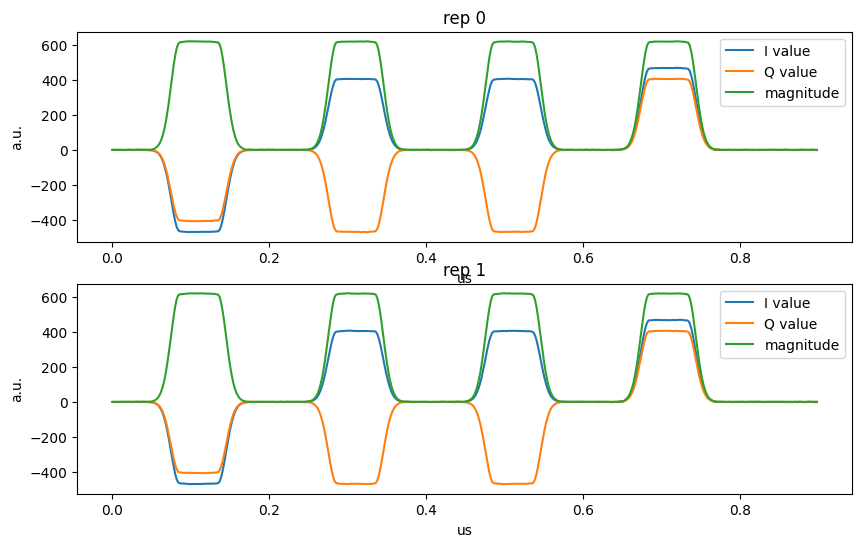

In [35]:
from qick.asm_v2 import AsmV2
class PulseUpdateProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        ramp_len = 0.1
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.05,
                       phase=0,
                       gain=1.0, 
                      )

        sub = AsmV2()
        for wname in self.list_pulse_waveforms("myflattop"):
            sub.read_wmem(name=wname)
            sub.inc_reg(dst='w_phase', src=self.deg2reg(90, gen_ch=cfg['gen_ch']))
            sub.write_wmem(name=wname)
        self.add_subroutine("virt_z", sub)

    
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.call("virt_z")
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0.2)
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0.4)
        self.call("virt_z")
        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0.6)

        # reset the phase to 0
        for wname in self.list_pulse_waveforms("myflattop"):
            self.read_wmem(name=wname)
            self.write_reg(dst='w_phase', src=0)
            self.write_wmem(name=wname)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.9,
         }

prog = PulseUpdateProgram2(soccfg, reps=2, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(len(iq_list[0]), 1, figsize=(10,6))

for ii, iq in enumerate(iq_list[0]):
    plot = axes[ii]

    plot.plot(t, iq[:,0], label="I value")
    plot.plot(t, iq[:,1], label="Q value")
    plot.plot(t, np.abs(iq.dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_title("rep %d"%(ii))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");

## understanding ASM and program structure
Nothing I say here should be entirely new to you - these concepts are basic to how QICK is used, and have not changed between tProc v1 and v2.

You build programs by calling a bunch of QickProgramV2 methods. These methods don't do anything when called, you are just writing your program at this point - you can build a QickProgramV2 or AveragerProgramV2 without even having a connection to a QICK board, as long as you have the QickConfig JSON object that defines the firmware configuration. The methods just define elements that you will use in your program, or add instructions that will be executed by the tProc.

A common misunderstanding related to this: new users will sometimes put code in their program's `_initialize()` or `_body()` that controls external equipment, or even the QICK itself (e.g. `soc.start_tproc()` or `soc.reset_gens()`). They expect that this code will be executed in sequence with the QICK instructions (and will get looped over, etc.). But what actually happens is that their code gets executed when the program is compiled, and not when the program is run. The Python code in the `_body()` is executed at compile time, so that's when the non-QICK code runs (and it only runs once); the QICK instructions are just adding code to the assembly-language program. In other words, they think their `_body()` looks like this:
```
    pulse generator 3
    trigger the AWG
    delay 1 us
    trigger readout 2
```
but it's this:
```
    append "pulse generator 3" to the ASM
    trigger the AWG
    append "delay 1 us" to the ASM
    append "trigger readout 2" to the ASM
```

There are two types of QickProgramV2 methods, let's call them "definitions" and "instructions."

### definitions
Definitions (which have names starting with `add_` or `declare_`) add things to the program metadata (pulses, envelopes, readouts, generators, etc.). They are not directly translated to tProc instructions, and so it doesn't really matter where you put these in your program; you can intersperse definitions with instructions, you can put definitions in your `_body()`, none of it will make any difference. As a matter of good code hygiene, it's nice to put definitions at the start of your `_initialize()`, to sort of separate the "setup" stuff from the code that actually runs as part of your experiment sequence.

AveragerProgramV2 has `add_loop()` and `add_subroutine()`, which are definitions and get translated to tProc code - what's going on here? These aren't *directly* translated to tProc code; the loop or subroutine doesn't appear in the tProc program at the point where you called the method. These methods are making notes for the AveragerProgramV2 compiler to generate tProc code in the appropriate place.

### instructions
Instructions are what make up the actual program; when you run a program, the tProc is stepping through your list of instructions to decide what to do. Instructions are methods of AsmV2. Most generally, they exist in the following forms:
* machine code: each instruction is 72 bits of binary data, this is what gets written into the program memory
* python ASM: each instruction is a Python dictionary
* text ASM: each instruction is a line of text
* AsmV2 macro

The two forms of ASM map directly onto each other and to machine code; with a few exceptions, one ASM instruction is one line of text ASM, one Python dictionary, or 72 bits of machine code, and one-to-one translation is possible from one format to another. The translation is done by the tProc v2 assembler. QickProgramV2 internally stores the ASM in Python format, and translates to ython ASM and then to Pmachine code when you run your program.

This is all pretty similar to tProc v1 (the 01 "phase coherence" demo walks you through the three different formats), but the ASM instruction set itself is completely different.

In tProc v1, the ASM instruction set was fairly simple (there were a bunch of instructions, each accepted some number of parameters), and it was pretty common to use ASM instructions directly (`prog.regwi()` directly adds a Python tuple to `prog.prog_list`), in addition to some `macro` instructions (`prog.set_pulse_registers()` does some bookkeeping and adds a bunch of Python tuples to `prog.prog_list`).
A simple loopback program without sweeps might only use macro instructions (which were documented in Python docstrings, ReadTheDocs, etc., and were designed to do specific high-level operations), but anything more would probably use ASM instructions (which were documented in the tProc manual, and were low-level building blocks that you'd need to put together to do what you wanted).

In tProc v2, the ASM instruction set is quite complex (few instructions, but many flags that change the flavor or the input types for each instruction). On the other hand, the tProc v2 is designed in a way that more closely aligns with the high-level operations you'd want to do; it's possible to build a set of macro instructions that should cover most use cases, and you should be able to write a tProc program purely in terms of high-level concepts (pulses, time steps, loops) and not think about registers or memories. This is a design goal of QickProgramV2.

So when you write a tProc v2 program, all instructions are macro instructions: `prog.pulse()` adds a `Pulse` object to `prog.macro_list`, and `Pulse.expand()` has some code that generates some python ASM objects. When you run your program, `prog.make_program()` fills `prog.macro_list` by running your `prog.initialize()` and `prog.body()` (plus some code of its own, to run the loops and sweep the parameters etc.), then the macros are "expanded" to python ASM and then to machine code.

If you want to do something that's not defined as a macro, you will need to mix ASM with macros, or define your own macro. The way you mix ASM with macros is by using `prog.asm_inst()`, which wraps an ASM dictionary in a macro and adds it to `prog.macro_list`. Often you won't know the proper format for the ASM dictionary, but you may have some text ASM example. In this case you can use the assembler to translate the text to dictionaries, and you can check that the text ASM and your QickProgramV2 give you the same machine code. If you want more convenience and flexibility, you can then define a macro that generates the ASM.

so, let's print the program we just ran:

In [36]:
print(prog)

macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5824911dd0>}, t_regs={'t': 384})
	OpenLoop(n=2, name='reps')
	Trigger(ros=[0], pins=[0], t=0.3, width=0.026041666666666668, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5824782810>, 'width': <qick.asm_v2.QickParam object at 0x7f5824911d90>}, t_regs={'t': 115, 'width': 10}, outdict=defaultdict(<class 'int'>, {1: 5, 0: 1}), trigset=set())
	Pulse(ch=7, name='myflattop', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5824910790>}, t_regs={'t': 0})
	AsmInst(inst={'CMD': 'CALL', 'LABEL': 'virt_z'}, addr_inc=1)
	Pulse(ch=7, name='myflattop', t=0.2, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5824911a50>}, t_regs={'t': 77})
	Pulse(ch=7, name='myflattop', t=0.4, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0x7f5824910350>}, t_regs={'t': 154})
	AsmInst(inst={'C

In [37]:
prog.prog_list

[{'P_ADDR': 1, 'LINE': 0, 'CMD': 'NOP'},
 {'CMD': 'REG_WR',
  'DST': 's12',
  'SRC': 'imm',
  'LIT': '#0',
  'P_ADDR': 1,
  'LINE': 1},
 {'CMD': 'TIME', 'C_OP': 'inc_ref', 'LIT': '#384', 'P_ADDR': 2, 'LINE': 2},
 {'CMD': 'REG_WR',
  'DST': 'r0',
  'SRC': 'imm',
  'LIT': '#2',
  'P_ADDR': 3,
  'LINE': 3},
 {'CMD': 'REG_WR',
  'DST': 's14',
  'SRC': 'imm',
  'LIT': '#115',
  'P_ADDR': 4,
  'LINE': 4},
 {'CMD': 'DPORT_WR',
  'DST': '1',
  'SRC': 'imm',
  'DATA': '5',
  'P_ADDR': 5,
  'LINE': 5},
 {'CMD': 'DPORT_WR',
  'DST': '0',
  'SRC': 'imm',
  'DATA': '1',
  'P_ADDR': 6,
  'LINE': 6},
 {'CMD': 'REG_WR',
  'DST': 's14',
  'SRC': 'op',
  'OP': 's14 + #10',
  'P_ADDR': 7,
  'LINE': 7},
 {'CMD': 'DPORT_WR',
  'DST': '1',
  'SRC': 'imm',
  'DATA': '0',
  'P_ADDR': 8,
  'LINE': 8},
 {'CMD': 'DPORT_WR',
  'DST': '0',
  'SRC': 'imm',
  'DATA': '0',
  'P_ADDR': 9,
  'LINE': 9},
 {'CMD': 'REG_WR',
  'DST': 's14',
  'SRC': 'imm',
  'LIT': '#0',
  'P_ADDR': 10,
  'LINE': 10},
 {'CMD': 'WPORT_WR',

### different program representations
Let's try defining the same (trivial, useless) program using text ASM, ASM dictionaries, macro objects, or macro methods.

This is more than a fun exercise - if you want to write a program with functionality that's present in the tProc but not in the AsmV2 macro set, you would start by writing your program (or the part that's new) in text ASM following the tProc v2 manual, and convert to ASM dictionaries. This is how the existing macros were developed.

In [38]:
# use the assembler to translate from text to the other ASM formats
from qick.tprocv2_assembler import Assembler
pstr = 'TIME #384 inc_ref\nREG_WR r_wave wmem [&0]\nWMEM_WR [&0]\n.END'
print("text ASM:")
print(pstr)

# convert text ASM to machine code
print("\nmachine code:")
for a in Assembler.str_asm2bin(pstr)[1]:
    print([hex(b) for b in a])

# convert text ASM to ASM dicts
print("\nASM dicts:")
plist,labels = Assembler.str_asm2list(pstr)
for a in plist:
    print(a)
for a in labels.items():
    print(a)

# convert ASM dicts back to text ASM
print("\ntext ASM -> ASM dicts -> text ASM:")
print(Assembler.list2asm(plist, labels))

text ASM:
TIME #384 inc_ref
REG_WR r_wave wmem [&0]
WMEM_WR [&0]
.END

machine code:
['0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
['0xc000', '0x8000000', '0x4c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0x9c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0xbe', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x8000', '0x3c', '0x0', '0x0', '0x0', '0x0', '0x0']

ASM dicts:
{'P_ADDR': 1, 'LINE': 2, 'CMD': 'NOP'}
{'P_ADDR': 1, 'LINE': 1, 'LIT': '#384', 'CMD': 'TIME', 'C_OP': 'inc_ref'}
{'P_ADDR': 2, 'LINE': 2, 'ADDR': '&0', 'CMD': 'REG_WR', 'DST': 'r_wave', 'SRC': 'wmem'}
{'P_ADDR': 3, 'LINE': 3, 'CMD': 'WMEM_WR', 'DST': '[&0]'}
{'LINE': 4, 'P_ADDR': 4, 'ADDR': '&4', 'CMD': 'JUMP'}
('s15', 's15')

text ASM -> ASM dicts -> text ASM:
     NOP 
     TIME ##384 inc_ref 
     REG_WR r_wave wmem [&0] 
     WMEM_WR [&0] 
     JUMP HERE 



In [39]:
from qick.asm_v2 import QickProgramV2
# use QickProgramV2 to write the same program using asm_inst
prog = QickProgramV2(soccfg)
prog.asm_inst({'CMD': 'TIME', 'C_OP': 'inc_ref', 'LIT': '#384'})
prog.asm_inst({'CMD': 'REG_WR', 'DST': 'r_wave', 'SRC': 'wmem', 'ADDR': '&0'})
prog.asm_inst({'CMD': 'WMEM_WR', 'DST': '[&0]'})

prog.end()
print("text ASM:")
print(prog.asm())

print("machine code:")
prog.compile()
for a in prog.binprog['pmem']:
    print([hex(b) for b in a])

text ASM:
     NOP 
     TIME ##384 inc_ref 
     REG_WR r_wave wmem [&0] 
     WMEM_WR [&0] 
     JUMP HERE 

machine code:
['0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
['0xc000', '0x8000000', '0x4c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0x9c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0xbe', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x8000', '0x3c', '0x0', '0x0', '0x0', '0x0', '0x0']


In [40]:
# the same program, using macro objects

from qick.asm_v2 import Waveform, ReadWmem, WriteWmem, Delay
prog = QickProgramV2(soccfg)
# add an empty waveform that we can play with
prog.add_raw_pulse("mypulse", [Waveform(0,0,0,0,0,0)])

prog.append_macro(Delay(t=1.0, auto=False))
for wname in prog.list_pulse_waveforms("mypulse"):
    prog.append_macro(ReadWmem(name=wname))
    prog.append_macro(WriteWmem(name=wname))
prog.end()

print("text ASM:")
print(prog.asm())
print("machine code:")
prog.compile()
for a in prog.binprog['pmem']:
    print([hex(b) for b in a])

text ASM:
     NOP 
     TIME ##384 inc_ref 
     REG_WR r_wave wmem [&0] 
     WMEM_WR &0 
     JUMP HERE 

machine code:
['0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
['0xc000', '0x8000000', '0x4c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0x9c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0xbe', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x8000', '0x3c', '0x0', '0x0', '0x0', '0x0', '0x0']


In [41]:
# the same program, using macro methods
# this is the most common way to write programs

from qick.asm_v2 import Waveform
prog = QickProgramV2(soccfg)
# add an empty waveform that we can play with
prog.add_raw_pulse("mypulse", [Waveform(0,0,0,0,0,0)])
prog.delay(1.0)
for wname in prog.list_pulse_waveforms("mypulse"):
    prog.read_wmem(name=wname)
    prog.write_wmem(name=wname)
prog.end()

print("text ASM:")
print(prog.asm())
print("machine code:")
prog.compile()
for a in prog.binprog['pmem']:
    print([hex(b) for b in a])

text ASM:
     NOP 
     TIME ##384 inc_ref 
     REG_WR r_wave wmem [&0] 
     WMEM_WR &0 
     JUMP HERE 

machine code:
['0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0', '0x0']
['0xc000', '0x8000000', '0x4c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0x9c', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x40000000', '0xbe', '0x0', '0x0', '0x0', '0x0', '0x0']
['0x0', '0x8000', '0x3c', '0x0', '0x0', '0x0', '0x0', '0x0']


### ways to run programs

If you just want to run a program (you don't care about acquisition - as in the example above, you may not even have declared any readouts, data dimensions, or shot counters), you can use `prog.run()`, which loads and starts your program and returns immediately. (This also exists for v1 programs.)

In [42]:
prog.run(soc)

If you want a little more control (you want to see your program's progress, or you want to run it repeatedly), your program base class needs to be AcquireProgramV2, and you need to define a shot counter in your program definition with `setup_counter()`, and you need to initialize and increment that counter with `set_ext_counter()` and `inc_ext_counter()`, then you can use `run_rounds()`.

If you also want to acquire data, you need to declare readouts and send some triggers, and then you can use `setup_acquire()` and `acquire()` - not shown here.

This example also shows how you write a loop by hand (instead of letting AveragerProgramV2 do it for you).

In [43]:
from qick.asm_v2 import AcquireProgramV2

reps = 1000

prog = AcquireProgramV2(soccfg)
prog.set_ext_counter(addr=1, val=0)
prog.open_loop(reps, "myloop")
prog.delay(1000.0) # 1 ms
prog.wait(0)
prog.inc_ext_counter(addr=1, val=1)
prog.close_loop()
prog.end()

prog.setup_counter(counter_addr=1, loop_dims=[reps])

print("text ASM:")
print(prog.asm())
# print("machine code:")
# prog.compile()
# for a in prog.binprog['pmem']:
#     print([hex(b) for b in a])

prog.run_rounds(soc)

text ASM:
     NOP 
     REG_WR s12 imm ##0 
     REG_WR r0 imm ##1000 
myloop:
     TIME ##384000 inc_ref 
     WAIT [&5] @@0 time 
     REG_WR s12 op -op(s12 + #1) 
     REG_WR r0 op -op(r0 - #1) -uf 
     JUMP myloop -if(NZ) 
     JUMP HERE 



  0%|          | 0/1000 [00:00<?, ?it/s]

## everything below is scratchwork

In [44]:
soc.reset_gens()